In [1]:
import sys
from importlib import reload 
sys.path.append('./lib')

In [2]:
import utils  # expand_to_hyperboloid
utils = reload(utils)

import distances  # Distances, ProductDistances
distances = reload(distances)
from distances import Distances, ProductDistances

import dssm  # DSSM_V2
dssm = reload(dssm)

import layers  # SphericalExponentialMapLayer, HyperbolicalExponentialMapLayer
layers = reload(layers)

__________________________

In [3]:
import networkx as nx
import math
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
import collections

from collections import defaultdict
from IPython.display import clear_output

import copy
import numpy as np
import tensorflow as tf
import pandas as pd

import scipy.stats as sps
import pickle

assert int(tf.__version__.split(".")[0]) >= 2

____________________
# Load data

In [4]:
train = pd.read_csv("./true_dssm/req_ans_learn.tsv", sep="\t", header=None)
np.random.seed(17)
train["rnd"] = np.random.rand(len(train))
train = train.sort_values("rnd")
train.head()

,0,1,rnd
144284,u.2,/wiki/U2,2.456372e-07
170822,Kris Wallace,/wiki/Chris_Wallace,1.309875e-06
61024,1980: Mitsubishi produces one million cars...,/wiki/Mitsubishi_Motors,4.676557e-06
201047,code napoleon,/wiki/Napoleonic_Code,1.120069e-05
305336,somersault!,/wiki/Somersault,1.305695e-05


In [5]:
def link_prepare(key):
    return key.split("/wiki/")[1].replace("_", " ")

def link_unprepare(key):
    return "/wiki/" + key.replace(" ", "_")

In [6]:
links = []
for i in tqdm.tqdm_notebook(range(len(train))):
    links.append(str(link_prepare(train.iloc[i][1])))
    assert link_unprepare(links[-1]) == train.iloc[i][1]

train[1] = np.array(links, dtype=str)

_________________
# Canonical

In [7]:
d = dssm.DSSM_V2(hid_size=512, emb_size=256)
dist = ProductDistances([
    (256, Distances("inverted_dot")),  # like regular dot, because we have another invertion in loss function
])

In [8]:
trainer = dssm.trainer.DssmTrainerWithCustomTokenizerAndHards(model=d, qs=train, hard_every=100,
    tokenizer_cfg={"total_tokens":30000, "triplets_weight":20, "pairs_weight":2, "words_weight":8})

100%|██████████| 441939/441939 [00:00<00:00, 686451.05it/s]


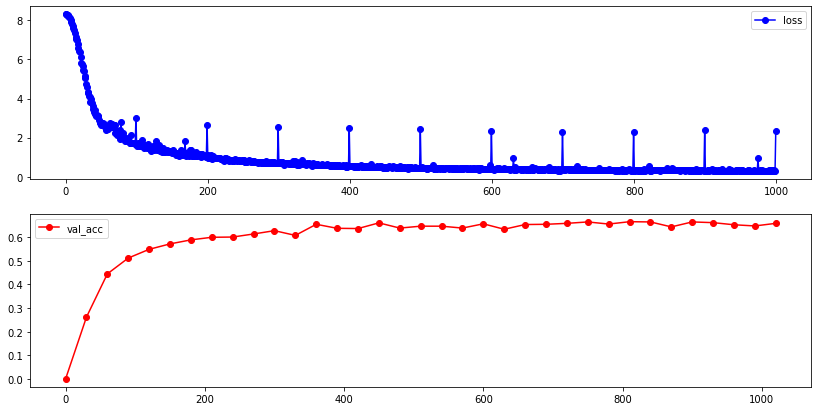

val_acc[-1] = 0.659



In [9]:
trainer.fit(d, dist, redraw_interval=30, iters=1000)

In [15]:
with open("dssm-exp-256-inverted_dot-2020-04-03.pickle", "wb") as f:
    pickle.dump(trainer.best_model_weights, f)

In [16]:
for w, b_w in zip(d.get_weights(), trainer.best_model_weights):
    w.assign(b_w)

In [17]:
trainer.get_val_acc(d, dist)

0.666

In [18]:
trainer.get_test_acc(d, dist)

0.6759596782405051

_______________________

In [8]:
def do_stuff(dist, name, date="2020-05-01"):
    d = dssm.DSSM_V2(hid_size=512, emb_size=256)
    trainer = dssm.trainer.DssmTrainerWithCustomTokenizerAndHards(model=d, qs=train, hard_every=9999,
        tokenizer_cfg={"total_tokens":30000, "triplets_weight":20, "pairs_weight":2, "words_weight":8})
    trainer.fit(d, dist, redraw_interval=30, iters=1000)
    with open(f"dssm-exp-256-{name}-nohn-{date}.pickle", "wb") as f:
        pickle.dump(trainer.best_model_weights, f)
    with open(f"dssm-exp-256-{name}-nohn-{date}-dist.pickle", "wb") as f:
        pickle.dump(trainer.best_dist_weights, f)
    for w, b_w in zip(d.get_weights(), trainer.best_model_weights):
        w.assign(b_w)
    for w, b_w in zip(dist.get_weights(), trainer.best_dist_weights):
        w.assign(b_w)
    return d, trainer

__________________

## Other Big Models

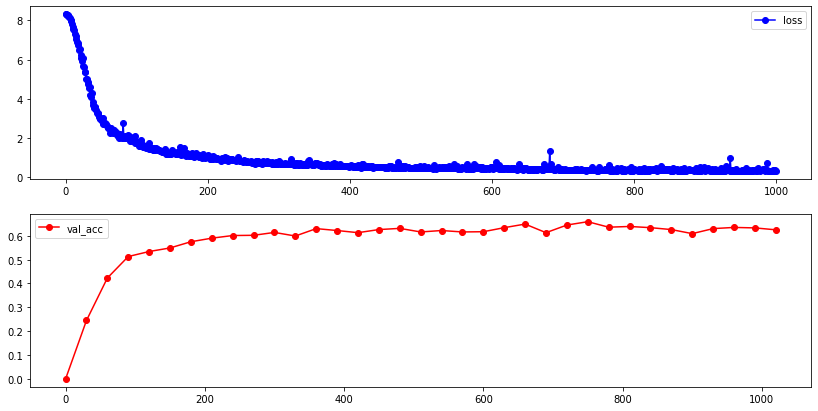

val_acc[-1] = 0.625



In [8]:
dist = ProductDistances([
    (256, Distances("inverted_dot")),
])
d, trainer = do_stuff(dist, "inverted_dot")

In [9]:
trainer.get_val_acc(d, dist, return_metrics=True)

{'hits': 659, 'total': 1000, 'map100': 0.7220250950931734, 'acc': 0.659}

In [10]:
trainer.get_test_acc(d, dist, return_metrics=True)

{'hits': 33069,
 'total': 49105,
 'map100': 0.7379768790394133,
 'acc': 0.6734344771408207}

_______________________

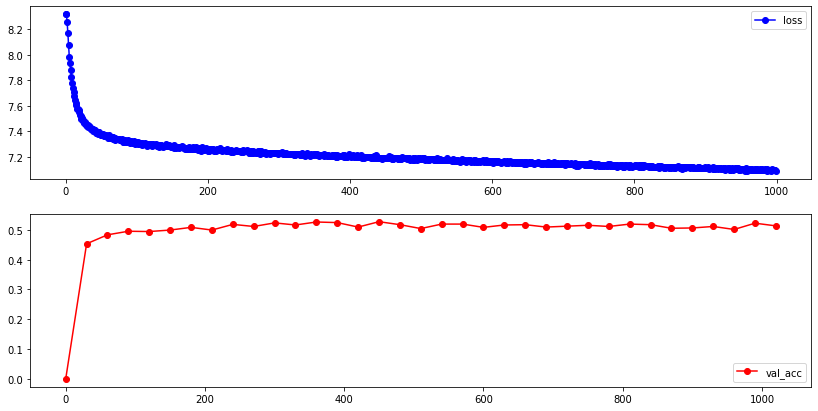

val_acc[-1] = 0.513



In [11]:
dist = ProductDistances([
    (256, Distances("spherical")),
])
d, trainer = do_stuff(dist, "spherical")

In [12]:
trainer.get_val_acc(d, dist, return_metrics=True)

{'hits': 527, 'total': 1000, 'map100': 0.5723487556155057, 'acc': 0.527}

In [13]:
trainer.get_test_acc(d, dist, return_metrics=True)

{'hits': 26223,
 'total': 49105,
 'map100': 0.5884685960140836,
 'acc': 0.5340189390082476}

________________________

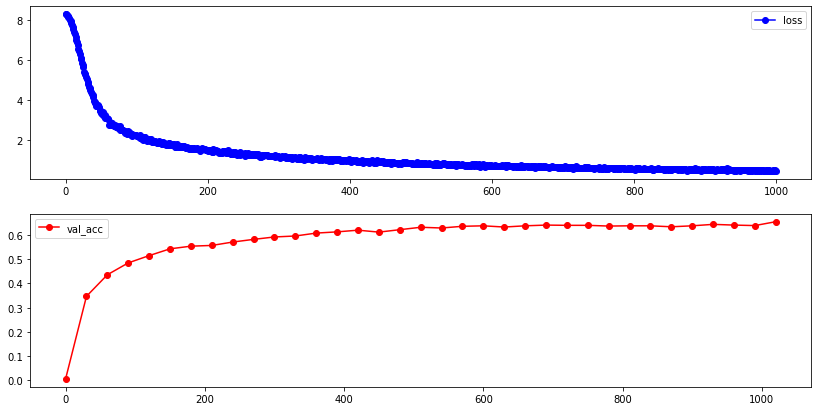

val_acc[-1] = 0.655



In [14]:
dist = ProductDistances([
    (256, Distances("euclidian")),
])
d, trainer = do_stuff(dist, "euclidian")

In [15]:
trainer.get_val_acc(d, dist, return_metrics=True)

{'hits': 655, 'total': 1000, 'map100': 0.7098521802911418, 'acc': 0.655}

In [16]:
trainer.get_test_acc(d, dist, return_metrics=True)

{'hits': 32166,
 'total': 49105,
 'map100': 0.7165001208587491,
 'acc': 0.6550453110681194}

_____________________________________________________

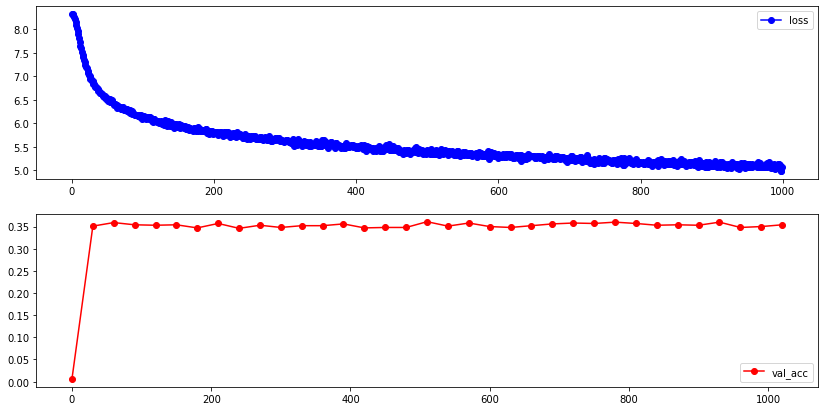

val_acc[-1] = 0.354



In [9]:
dist = ProductDistances([
    (256, Distances("expanded_hyp")),
])
d, trainer = do_stuff(dist, "expanded_hyp")

In [10]:
trainer.get_val_acc(d, dist, return_metrics=True)

{'hits': 361, 'total': 1000, 'map100': 0.3973451463468101, 'acc': 0.361}

In [11]:
trainer.get_test_acc(d, dist, return_metrics=True)

{'hits': 18339,
 'total': 49105,
 'map100': 0.41185208312904986,
 'acc': 0.3734650239283169}

___________________________________

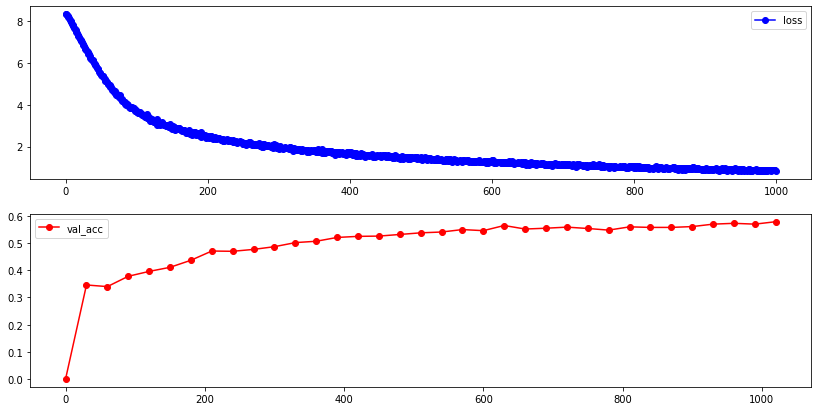

val_acc[-1] = 0.579


In [13]:
dist = ProductDistances([
    (256, Distances("triple_trainable_l1_corrected")),
])
d, trainer = do_stuff(dist, "triple_trainable_l1_corrected")

In [14]:
trainer.get_val_acc(d, dist, return_metrics=True)

{'hits': 579, 'total': 1000, 'map100': 0.6467018525279352, 'acc': 0.579}

In [16]:
v = trainer.get_test_acc(d, dist, return_metrics=True)
v

{'hits': 29318,
 'total': 49105,
 'map100': 0.6621805901901104,
 'acc': 0.5970471438753691}

In [19]:
tf.nn.softmax(dist.get_weights())

<tf.Tensor: id=76699627, shape=(1, 9), dtype=float64, numpy=
array([[0.20631648, 0.06224998, 0.07103721, 0.19574814, 0.06286912,
        0.07100618, 0.19680566, 0.06279997, 0.07116726]])>

___________________________________

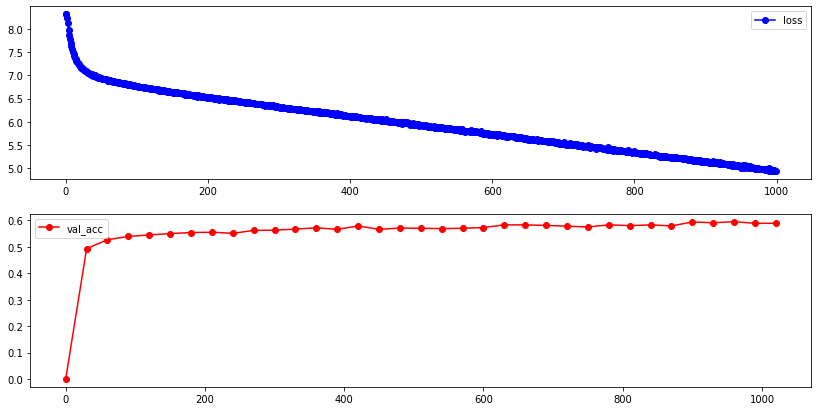

val_acc[-1] = 0.589


In [20]:
dist = ProductDistances([
    (128, Distances("spherical", scalable=True)),
    (128, Distances("spherical", scalable=True)),
])
d, trainer = do_stuff(dist, "S_128xS_128")

In [21]:
trainer.get_val_acc(d, dist, return_metrics=True)

{'hits': 595, 'total': 1000, 'map100': 0.6513441221117158, 'acc': 0.595}

In [22]:
trainer.get_test_acc(d, dist, return_metrics=True)

{'hits': 29730,
 'total': 49105,
 'map100': 0.6618175354151091,
 'acc': 0.6054373281743204}

___________________________________

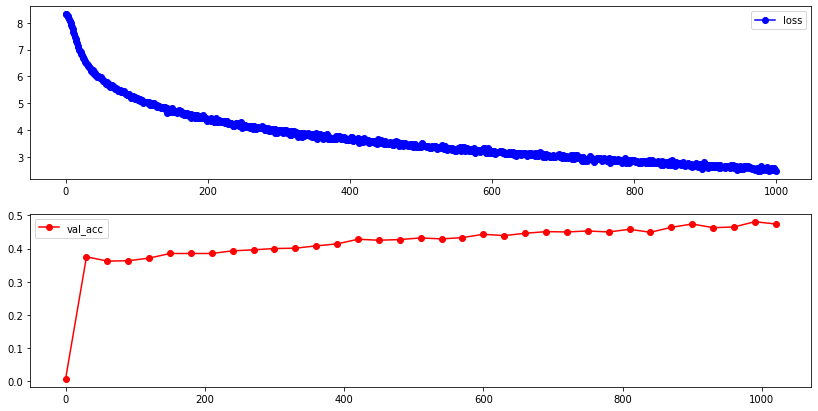

val_acc[-1] = 0.474


In [23]:
dist = ProductDistances([
    (128, Distances("expanded_hyp", scalable=True)),
    (128, Distances("expanded_hyp", scalable=True)),
])
d, trainer = do_stuff(dist, "H_128xH_128")

In [24]:
trainer.get_val_acc(d, dist, return_metrics=True)

{'hits': 481, 'total': 1000, 'map100': 0.5331987383855884, 'acc': 0.481}

In [25]:
trainer.get_test_acc(d, dist, return_metrics=True)

{'hits': 24336,
 'total': 49105,
 'map100': 0.5467744651211288,
 'acc': 0.4955910803380511}

___________________________________

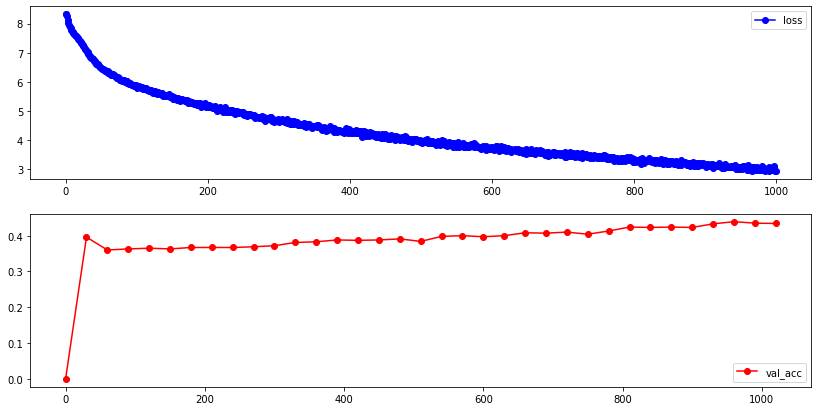

val_acc[-1] = 0.434


In [32]:
dist = ProductDistances([
    (128, Distances("expanded_hyp", scalable=True)),
    (128, Distances("spherical", scalable=True)),
])
d, trainer = do_stuff(dist, "H_128xS_128")

In [33]:
trainer.get_val_acc(d, dist, return_metrics=True)

{'hits': 439, 'total': 1000, 'map100': 0.48535875813854545, 'acc': 0.439}

In [34]:
trainer.get_test_acc(d, dist, return_metrics=True)

{'hits': 22318,
 'total': 49105,
 'map100': 0.5015847675564187,
 'acc': 0.4544954688931881}

___________________________________

In [26]:
d = dssm.DSSM_V2(hid_size=512, emb_size=256)
dist = ProductDistances([
    (51, Distances("expanded_hyp", scalable=True)),
    (51, Distances("expanded_hyp", scalable=True)),
    (51, Distances("expanded_hyp", scalable=True)),
    (51, Distances("expanded_hyp", scalable=True)),
    (52, Distances("expanded_hyp", scalable=True)),
])

In [27]:
trainer = dssm.trainer.DssmTrainerWithCustomTokenizerAndHards(model=d, qs=train, hard_every=9999,
    tokenizer_cfg={"total_tokens":30000, "triplets_weight":20, "pairs_weight":2, "words_weight":8})

100%|██████████| 441939/441939 [00:00<00:00, 667592.69it/s]


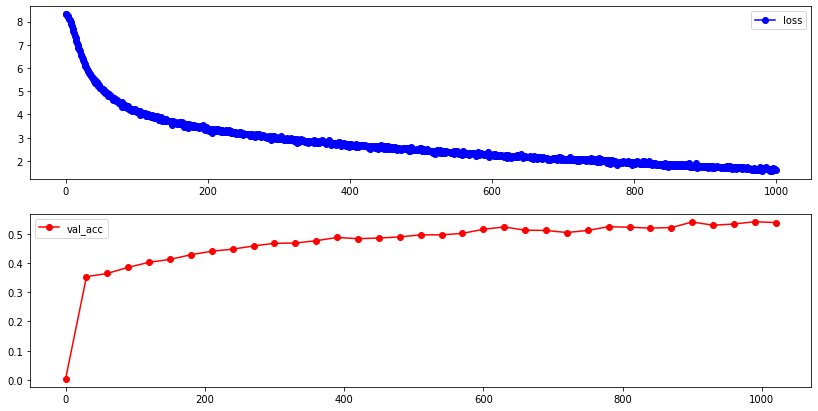

val_acc[-1] = 0.538



In [28]:
trainer.fit(d, dist, redraw_interval=30, iters=1000)

In [29]:
with open("dssm-exp-256-H_51(52)^5-2020-04-04.pickle", "wb") as f:
    pickle.dump(trainer.best_model_weights, f)

In [30]:
for w, b_w in zip(d.get_weights(), trainer.best_model_weights):
    w.assign(b_w)

In [31]:
trainer.get_val_acc(d, dist)

0.541

In [32]:
trainer.get_test_acc(d, dist)

0.564015884329498

In [33]:
dist.get_weights()

[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8130572848477535>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8090709683422102>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.806992024323885>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8053772298826367>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8036862132433518>]

In [35]:
tf.nn.softmax(dist.get_weights())

<tf.Tensor: id=72990555, shape=(5,), dtype=float64, numpy=array([0.20108599, 0.200286  , 0.19987005, 0.19954756, 0.1992104 ])>

In [36]:
trainer.get_val_acc(d, dist, return_metrics=True)

{'hits': 541, 'total': 1000, 'map100': 0.597690219076182, 'acc': 0.541}

In [37]:
trainer.get_test_acc(d, dist, return_metrics=True)

{'hits': 27696,
 'total': 49105,
 'map100': 0.6206690971284637,
 'acc': 0.564015884329498}

___________________________________

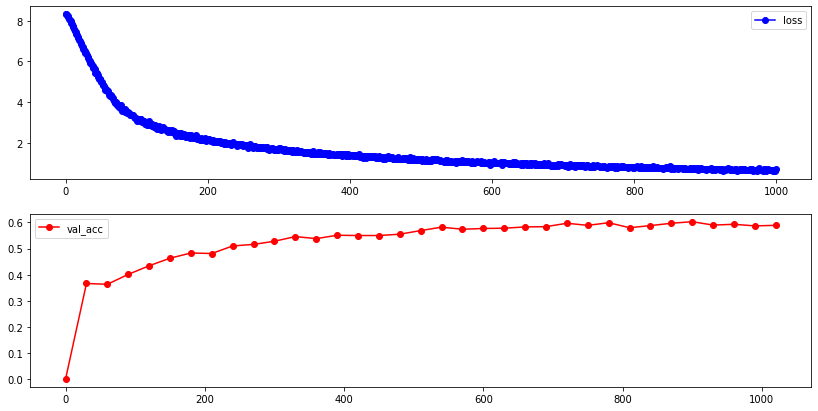

val_acc[-1] = 0.589


In [35]:
dist = ProductDistances([
    (256, Distances("triple_trainable_l0_corrected", scalable=True)),
])
d, trainer = do_stuff(dist, "ttl0_256")

In [36]:
trainer.get_val_acc(d, dist, return_metrics=True)

{'hits': 603, 'total': 1000, 'map100': 0.6646287757732009, 'acc': 0.603}

In [37]:
trainer.get_test_acc(d, dist, return_metrics=True)

{'hits': 30040,
 'total': 49105,
 'map100': 0.6771221432011832,
 'acc': 0.6117503309235313}

___________________________________

In [41]:
d = dssm.DSSM_V2(hid_size=512, emb_size=256)
dist = ProductDistances([
    (51, Distances("spherical", scalable=True)),
    (51, Distances("spherical", scalable=True)),
    (51, Distances("spherical", scalable=True)),
    (51, Distances("spherical", scalable=True)),
    (52, Distances("spherical", scalable=True)),
])

In [42]:
trainer = dssm.trainer.DssmTrainerWithCustomTokenizerAndHards(model=d, qs=train, hard_every=9999,
    tokenizer_cfg={"total_tokens":30000, "triplets_weight":20, "pairs_weight":2, "words_weight":8})

100%|██████████| 441939/441939 [00:00<00:00, 654068.84it/s]


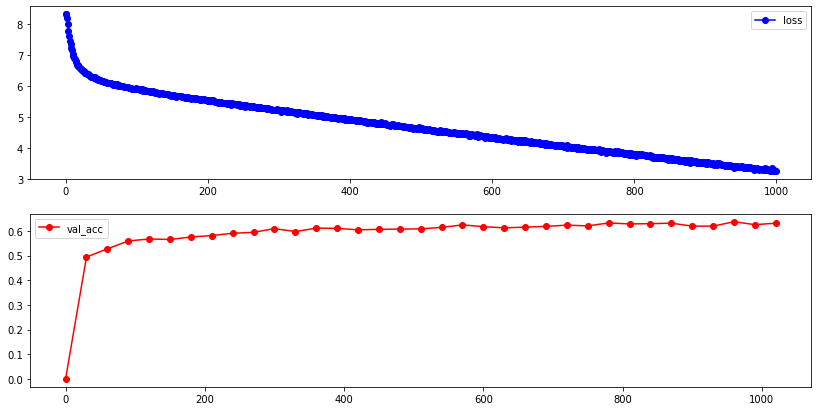

val_acc[-1] = 0.631


In [43]:
trainer.fit(d, dist, redraw_interval=30, iters=1000)

In [44]:
with open("dssm-exp-256-S_51(52)^5-2020-04-04.pickle", "wb") as f:
    pickle.dump(trainer.best_model_weights, f)

In [45]:
for w, b_w in zip(d.get_weights(), trainer.best_model_weights):
    w.assign(b_w)

In [46]:
trainer.get_val_acc(d, dist, return_metrics=True)

{'hits': 637, 'total': 1000, 'map100': 0.6861042595565414, 'acc': 0.637}

In [47]:
trainer.get_test_acc(d, dist, return_metrics=True)

{'hits': 31733,
 'total': 49105,
 'map100': 0.7012605483194304,
 'acc': 0.6462274717442216}

In [48]:
dist.get_weights()

[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.037892487355593>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.043603941186293>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.035431219544088>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0377391077659146>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.040120878389829>]

In [49]:
tf.nn.softmax(dist.get_weights())

<tf.Tensor: id=122304120, shape=(5,), dtype=float64, numpy=array([0.19978635, 0.20093068, 0.19929522, 0.19975571, 0.20023204])>

_____________________________

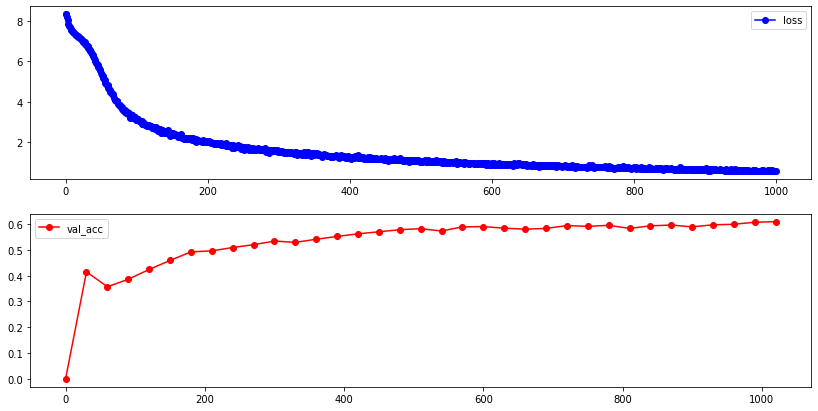

val_acc[-1] = 0.609


In [38]:
dist = ProductDistances([
    (51, Distances("expanded_hyp", scalable=True, dtype=d.dense_in_1.dtype)),
    (51, Distances("expanded_hyp", scalable=True, dtype=d.dense_in_1.dtype)),
    (51, Distances("spherical", scalable=True, dtype=d.dense_in_1.dtype)),
    (51, Distances("spherical", scalable=True, dtype=d.dense_in_1.dtype)),
    (52, Distances("euclidian", scalable=True, dtype=d.dense_in_1.dtype)),
])
d, trainer = do_stuff(dist, "E52xS51xS51xH51xH51")

In [39]:
trainer.get_val_acc(d, dist, return_metrics=True)

{'hits': 609, 'total': 1000, 'map100': 0.6730492587086546, 'acc': 0.609}

In [40]:
trainer.get_test_acc(d, dist, return_metrics=True)

{'hits': 30487,
 'total': 49105,
 'map100': 0.684063356840696,
 'acc': 0.6208532735973934}

________________________